# Problem 2 defination:
2. Schedule LPG delivery in order to maximise the amount of gas delivered to the customers, while minimising the overall cost of delivery (including any potential penalties! - see below) and while observing the following constraints in addition to tanker lorry capacity:

* a. Each lorry can travel up to 250 miles.
* b. Each lorry can only stop up to 5 times, this includes customer deliveries and any additional visits to the depot.
* c. Each lorry must end its journey in one of the depots (this doesn’t count towards the 5 stop limit and doesn’t have to be the depot from which the lorry started its journey).
* d. If you don’t deliver to customers who have less than 15% of gas in their tanks, SaO Gas Ltd will incur a penalty of £1,000 for each such customer.

Solution is same as greedy algorithm. End goal is not defined but it changes after every itteration. untill it is not nearer to the defined goal. 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
genes = pd.read_csv("SaO_Optilandia_locations.csv")
df_link = pd.read_csv("SaO_Optilandia_links.csv")
#Get all lorries ids
with open('SaO_Optilandia_depot_lorries.json') as json_file:
    depot_lorries = json.load(json_file)

In [3]:
AllGenesDistance = squareform(pdist(genes[['x', 'y']]))


# Creating edges will from depot to customer

In [4]:
edges  = [(id1, id2, AllGenesDistance[id1, id2]) for _, (id1, id2) in df_link.iterrows()]
depot_genes, cust_genes = np.where(genes.is_depot)[0], np.where(genes.is_customer)[0]
depo_and_cust_genes = np.sort(np.concatenate((depot_genes, cust_genes)))

**DIFF:** To get difference between two list variable

Ex. a=[1,2,3,4]
    b=[4,5,6,7]
    Diff(a,b)
    => [1, 2, 3, 5, 6, 7]

In [5]:
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

**Visualization of graph using networkx:**

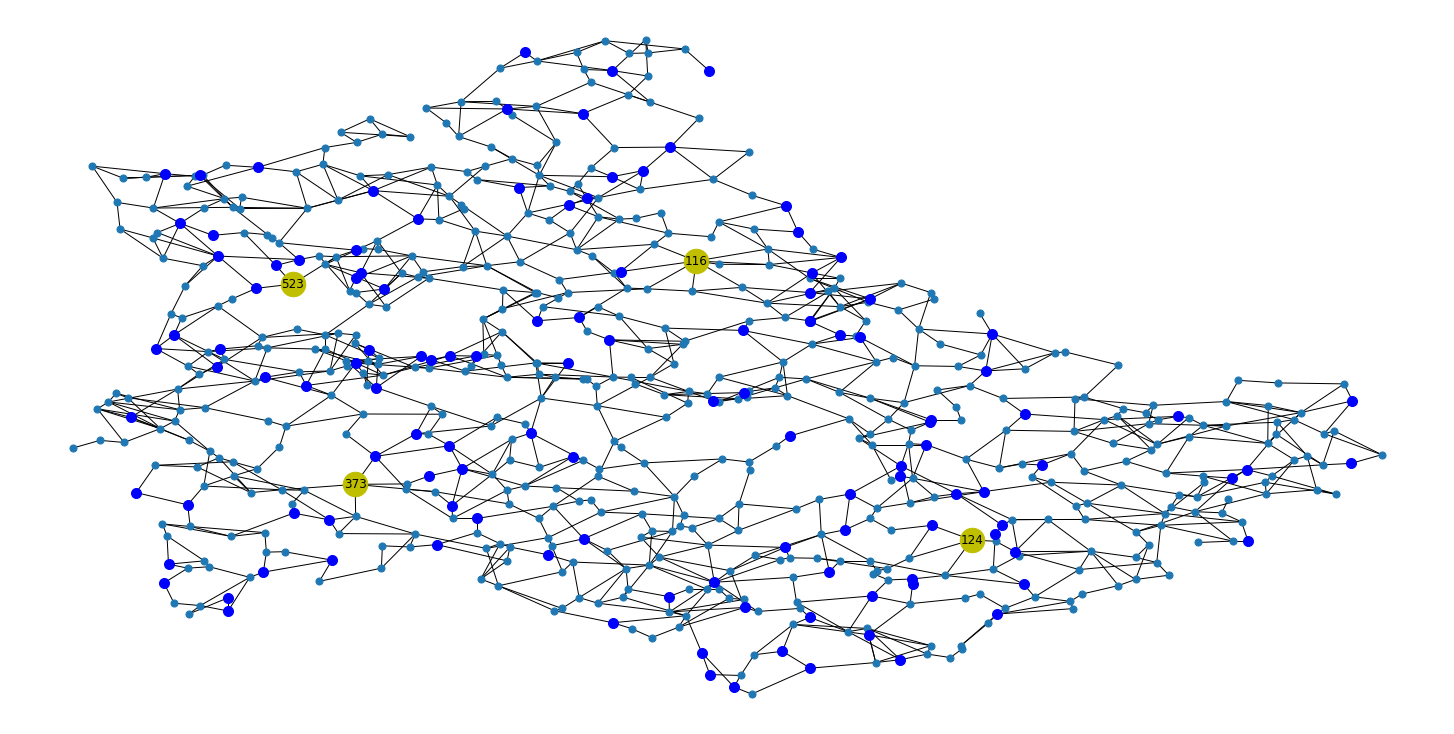

In [6]:
G = nx.Graph()
G.add_nodes_from(range(len(genes)))
G.add_weighted_edges_from(edges)
pos={k:v.values for k,v in genes[['x', 'y']].iterrows()}

plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,pos=pos,node_size=50)

nx.draw_networkx_nodes(G,pos,nodelist=depot_genes,node_color='y',node_size=600,alpha=1);
nx.draw_networkx_labels(G,pos,{k:k for k in depot_genes});
nx.draw_networkx_nodes(G,pos,nodelist=cust_genes,node_color='b',node_size=100,alpha=1);


**Create a matrix which shows the shortest path between the nodes:**

In [7]:
length = dict(nx.shortest_path_length(G, weight='weight'))
dist_graph =  np.array([[length[i][j] for i in range(len(G.nodes))] for j in range(len(G.nodes))])

**SourceToDestPath:**

To get short path from location A to location B
Ex. sourceToDestPath(523,240) => [523, 70, 402, 33, 276, 579, 588, 543, 597, 79, 240]



In [8]:
def sourceToDestPath(source, dest):
    shortest = nx.shortest_path(G,source=source,target=dest)
    #print(shortest)
    return shortest

### Returns path of input gene to every other gene

**oneToAllPath:**

Get all path from location A to all other location.

Ex. location =[1,2,.....10]

All path from 1 to 2, 1 to 3, 1 to 4, .... 1 to 10

oneToAllPath(1)=> [ all path from 1 to [1,2,3...10]

In [9]:
def oneToAllPath(node):
    shortest = nx.single_source_shortest_path(G,node)
    paths = []
    for indx in range(len(shortest)):
        paths.append(shortest[indx])
    return paths

**oneToAllPathLength:**

Get length from location a to all other location.

length means howmany other juction we need to travel from location A to reach location B

Ex. location =[1,2,.....10]

All path length from 1 to 2, 1 to 3, 1 to 4, .... 1 to 10

if path is location 1 to location 2 = [1,1.5,1.8,1.4,2]

oneToAllPath(1)=> 2: 4 => from location 1 to location 2 there are 4 stop

In [10]:
def oneToAllPathLength(node):
    alllength = nx.single_source_shortest_path_length(G,node)
    return alllength

In [11]:
genes

,id,x,y,is_depot,is_customer,capacity,level
0,0,49525.5556,5940.5556,False,False,NaN,NaN
1,1,49738.8889,6345.0000,False,False,NaN,NaN
2,2,49608.3333,6405.8333,False,False,NaN,NaN
3,3,49796.6667,6155.5556,False,False,NaN,NaN
4,4,49828.6111,5764.7222,False,False,NaN,NaN
...,...,...,...,...,...,...,...
629,629,49533.3333,5900.0000,False,False,NaN,NaN
630,630,49533.6111,6080.8333,False,False,NaN,NaN
631,631,49484.7222,6097.7778,False,False,NaN,NaN
632,632,49530.8333,6355.0000,False,True,1.5,0.26


***Population matrix contains shortest paths of every gene to every other gene***

In [12]:
# Add individual in population
populations = []
for x in range(len(genes)):
    shortest = oneToAllPath(x)
    populations.append(shortest)
populations[523][256]

[523, 99, 219, 429, 96, 493, 575, 293, 102, 256]

**oneToAllGenesPopulation:**

Returns all paths going from input gene

oneToAllGenesPopulation(Location A) => Find all path where we need to travel location A. (Return all path of involving Location A)

In [13]:
def oneToAllGenesPopulation(node):
    shortest = nx.single_source_shortest_path(G,node)
    paths = []
    for indx in range(len(shortest)):
        if indx in depo_and_cust_genes:
            paths.append(shortest[indx])
    return paths

Now onwards we are going to focus on customer and depot only so we are going to ignore all other path which we do not need for further caculation

In [14]:
customerPopulations = [] # All path where all customer and depot are involved
for x in range(len(genes)):
    if x in depo_and_cust_genes:
        shortest = oneToAllGenesPopulation(x)
        customerPopulations.append(shortest)
print(customerPopulations[np.where(depo_and_cust_genes == 5)[0][0]][np.where(depo_and_cust_genes == 8)[0][0]])

[5, 113, 386, 422, 349, 429, 219, 8]


**calculatePathFitness**: This function is calculating total distance for the given path

In [15]:
#returns path fitness
def calculatePathFitness(path):
    dist = 0
    for indx, val in enumerate(path):
        if indx<len(path)-1:
            dist = dist + dist_graph[val, path[indx + 1]]
    return dist

**calculatePathRequirement**: This function is calculating total reqirement of gas for the given path

In [16]:
def calculatePathRequirement(path):
    req = 0
    for indx, val in enumerate(path):
        if indx != 0:
            if val in cust_genes:
                if indx<len(path)-1:
                    req = req + customer_requirements.get(val)
    return req

Below code is use to know customer requirement and howmany percentage gas are their in tank

Ex. requirement of customer numbe 70 and percentage of gas available.

customer_requirements[70] => 1.46

level_filled[70] => 2.666666666666667

In [17]:
capLevel = genes[['capacity', 'level']]
customer_requirements = '{}' # Create JSON veriable to get individual customer requirement 
customer_requirements = json.loads(customer_requirements)       #contains gas requirements of all customers
for indx in range(len(capLevel)):
    if (math.isnan(capLevel['capacity'][indx])):
        pass
    else:
        newItem = {indx : capLevel['capacity'][indx]-capLevel['level'][indx]}
        customer_requirements.update(newItem)

level_filled = '{}' # Create JSON veriable to get level of gas in each customer tank 
level_filled = json.loads(level_filled)
for indx in range(len(capLevel)):
    if (math.isnan(capLevel['capacity'][indx])):
        pass
    else:
        newItem = {indx : (capLevel['level'][indx]/capLevel['capacity'][indx])*100}
        level_filled.update(newItem)

**FitnessMatrix:** This matrix use to choose next location so we can deliver gas maximum with minimum travelling distance

In [18]:
print("FitnessMatrix")
FitnessMatrix = [[None] * len(genes)] * len(genes) # Stor fitness score on their requirement and total distance to travel
for x in range(len(genes)):
    row = []
    for y in range(len(genes)):
        if x==y:
            FitnessMatrix[x][y]=0 # Same location
            continue
        if y in customer_requirements:
            FitnessMatrix[x][y] = customer_requirements[y] / dist_graph[x, y] # to minimize the cost of travelling and maximize the delivery of gas
        else:
            FitnessMatrix[x][y]=-1 # Juction 
    FitnessMatrix.append(row)
print(str(FitnessMatrix))

FitnessMatrix


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Note: ### 
Increasing the data rate of jupyter for the fitness matrix jupyter notebook --NotebookApp.iopub_data_rate_limit=1e12

In [19]:
#customer to customer distance matrix
customerTOcustomerDistance = [[None] * len(genes)] * len(genes) # To get customer to customer distance only 
print("customerTOcustomerDistance: ", len(customerTOcustomerDistance))
for x in depo_and_cust_genes:
    row = []
    for y in depo_and_cust_genes:
        if x==y:
            customerTOcustomerDistance[x][y]=0
        elif y in customer_requirements:
            path = sourceToDestPath(x,y)
            customerTOcustomerDistance[x][y] = calculatePathFitness(path) # if customer then calculate distance 
        else:
            customerTOcustomerDistance[x][y]=-1 
        customerTOcustomerDistance.append(row)

print("\n\n\n ---------------------------customerTOcustomerDistance--------------------------------- \n\n\n")
print(str(customerTOcustomerDistance))


customerTOcustomerDistance:  634



 ---------------------------customerTOcustomerDistance--------------------------------- 





IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# Create json file for solution checker
def createJSONFile(data,cost):
    file_name = str(cost)+".json"
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)
    print("File save as "+file_name)
    return file_name

In [21]:
#initializations
covered_customers = [] # To prevent lorry to travel same customer 
visited_genes = [] # All visited customer; either it is important(tank have less than 15% level) or not 
current_path_list = [] # All customer of single lorry travelling
distance_travelled = 0 # total distance lorry covering for one trip
imp_cust_left  = [] # Howmany customer with less than 15% of gas in tank
max_lorry_distance = 250 # One lorry can travel max 250 miles

In [22]:
all_chromosomes = json.loads('{}') # Get all paths which satisfiy our constrain for each lorry
all_chromosomes_requirements = json.loads('{}')     #requirement of all chromosomes/paths

In [23]:
FitnessMatrix[523][260] , FitnessMatrix[523][449]

(0.2533255860578987, 0.02403960062913738)

In [24]:
np.argsort(-np.array(FitnessMatrix[523]), axis=0)

array([260, 449, 411, 507, 204, 220, 175,  36, 130, 539, 254, 160, 171,
       446, 372, 169, 206, 214, 110, 459, 105, 542, 397, 177, 147, 264,
       606,  63, 205,  14, 364, 418, 547, 476,  22, 377, 598, 118,  32,
        64, 100, 393, 135, 146, 437, 362,  70,  86, 374, 180, 585, 497,
        78,  94, 271, 210, 172, 566, 398, 387, 294,  77, 391, 632, 332,
       534, 276,  44, 245, 603, 243,  27, 103, 453, 324,  31, 216,  41,
       337, 408, 265, 431, 520, 225, 308,  29, 543, 400,  65, 202, 378,
       144, 624, 200,  82, 474, 550, 455, 113, 190, 183,  73, 136,  80,
       621, 235, 270,  13, 491, 511, 584, 274, 380,   8, 519, 257, 528,
       569, 255, 531,   5, 389, 633, 424, 456, 370, 454, 371, 373, 375,
       452, 376, 457, 379, 381, 450, 382, 383, 384, 385, 386, 448, 451,
       458, 369, 368, 355, 356, 467, 357, 358, 359, 360, 466, 361, 363,
       365, 465, 366, 464, 463, 462, 461, 367, 460, 388, 447, 390, 445,
       434, 433, 412, 432, 413, 430, 414, 415, 416, 417, 468, 42

**createChromosomes:**

Start from first lorry to last and visit all customers who have more sortage then others and travel till our contrain reach.

Ex. Lorry 523-0 will travell all customer who are nearby and lorry can deliver maximum gas in minimum cost.

In [25]:
#create chromosemes
def createChromosomes():
    print("\n\n Depots List: ", depot_genes, "\n\n")
    origin_gene = 0
    prev_gene = 0
    next_gene = 0

    for depo_id in depot_genes:
        print("~~~~~~~~~~~~~~~~~~~ depot changed to ", depo_id, "~~~~~~~~~~~~~~~~~~~")
        current_path_list.clear() # new lorry new path list
        origin_gene = depo_id # Original start from depot
        prev_gene = depo_id 
        distance_travelled = 0
        current_path_list.append(prev_gene) # Add customer which we have visited for current lorry
        covered_customers = []
        all_chromosomes.update({depo_id : []})
        selected_depo_id = 0 # After visiting customer which depot is closer and stop nearest depot
        # Below loop continue till lorry find maximum 5 customer within 250 miles of distance.
        while (True):

                next_node_arr = np.array(FitnessMatrix[prev_gene])              #get all rechable paths of current gene
                next_node_arr_sorted_indx = np.argsort(-next_node_arr, axis=0)  #sort by fittest

                got_a_gene = False

                #checking every reachable node to satisfy our conditions
                for max_value_index in next_node_arr_sorted_indx:
                    if(prev_gene==origin_gene and max_value_index not in covered_customers):
                        covered_customers.append(max_value_index) # To mark one of the lorry has visited this location
                    if max_value_index!=origin_gene and max_value_index in cust_genes and (max_value_index not in visited_genes): #Check current location is not starting location and current location is depot and not visited before
                        
                        # calculate (travelled distance + distance to go + returning distance)
                        distance_to_check = distance_travelled + dist_graph[prev_gene][max_value_index] 
                        # distance = distance_to_check + dist_graph[max_value_index][origin_gene]
                        if(distance_to_check > max_lorry_distance): # we stop when we reach out maximum limit of 250
                            continue

                        target_to_depo_distances = dist_graph[max_value_index, depot_genes]    #gettign distances from target to all depots ex: [234, 125, 567, 398]
                        target_reachbale = ((target_to_depo_distances + distance_to_check) < max_lorry_distance)    #checkin which depot is rechable ex: [False, False, True, False] : here, 3rd depot is rechable

                        #checking if any depot is rechable && current path should not contain more than 5 visitors
                        if(len(np.where(target_reachbale == True)[0])>0 and len(current_path_list)<=6):
                            # we have a depo reachble from the next node
                            selected_depo_id= depot_genes[target_reachbale][0] # This might be not original depot but nearest depot from last location
                            got_a_gene = True
                            distance_travelled = distance_to_check
                            print(distance_travelled)
                            current_path_list.append(max_value_index)
                            prev_gene = max_value_index
                            visited_genes.append(prev_gene)     #add gene to visited_gene which satisfy all the conditions
                            break

                # if there is no more customer is suitable for this lorry or no customer in given constrain then it is the time to return to depot.
                cnt=len(current_path_list)
                if (cnt>1 and cnt<=6 and got_a_gene==False): # Checking lorry took maximum 5 stop
                    distance_travelled = distance_travelled + dist_graph[current_path_list[len(current_path_list) - 1], selected_depo_id]
                    current_path_list.append(selected_depo_id)
                    all_chromosomes[depo_id].append(np.array(current_path_list))
                    print("final node if ", len(current_path_list), " current_path_list ", current_path_list, " distance_travelled ", distance_travelled)
                    #print("visited_genes ", len(visited_genes), " ==== ", visited_genes)
                    prev_gene = depo_id
                    distance_travelled = 0
                    current_path_list.clear()
                    current_path_list.append(prev_gene)
                # print("final node if ", len(current_path_list), " current_path_list ", current_path_list," got_a_gene ",got_a_gene," covered_customers ",len(covered_customers))
                if(len(covered_customers)==634): #There are no more customer to check
                    print("breaking from here")
                    distance_travelled = 0
                    break


    print("\n\n------------------------------ all outputs below ------------------------------")
    print("visited_genes == ", len(visited_genes), " ==== ", np.array(visited_genes).tolist(), " ------ ", np.array(cust_genes).tolist())
    customers_not_visited = Diff(np.array(cust_genes).tolist(), np.array(visited_genes).tolist())
    print("customers not visited = ", len(customers_not_visited), " ==> ", customers_not_visited)
    print("paths from every depot == ", all_chromosomes)

    for depo in all_chromosomes:
        all_chromosomes_requirements.update({depo : []})
        for key,val in enumerate(all_chromosomes[depo]):
            requ = calculatePathRequirement(val)
            all_chromosomes_requirements[depo].append(requ)

    print("total requirement of each path ==  ", all_chromosomes_requirements)

    not_visited_dist = []
    for node in customers_not_visited:
        row = json.loads('{}')
        row.update({node : []})
        for depo in depot_genes:
            row[node].append(dist_graph[node, depo])
        not_visited_dist.append(row)
    print("\nnot_visited_dist : ", not_visited_dist)


    print("level_filled " , level_filled)
    imp_cust = []
    for key in level_filled:
        if level_filled[key] < 15:
            imp_cust.append(key)
    print("\nimp_cust  : ", len(imp_cust))

    for cust in imp_cust:
        if cust not in visited_genes:
            imp_cust_left.append(cust)
    print("imp_cust_left => ", len(imp_cust_left), "  ==>  ", imp_cust_left)


Above function will find the that how many customer has got the gas 

In [26]:
createChromosomes()



 Depots List:  [116 124 373 523] 


~~~~~~~~~~~~~~~~~~~ depot changed to  116 ~~~~~~~~~~~~~~~~~~~
120.64026831189332
143.4281912558552
144.3065455010204
final node if  5  current_path_list  [116, 459, 437, 528, 116]  distance_travelled  241.28053662378665
109.68055124477914
123.06010815859354
final node if  4  current_path_list  [116, 146, 624, 116]  distance_travelled  246.12021631718707
120.5758947517514
143.95707571978136
final node if  4  current_path_list  [116, 271, 453, 116]  distance_travelled  241.1517895035028
43.501309048006036
164.80892939627947
final node if  4  current_path_list  [116, 398, 31, 116]  distance_travelled  242.61524069654686
89.80229223128475
137.1855775545664
final node if  4  current_path_list  [116, 243, 265, 116]  distance_travelled  249.1585230011745
114.7869588199278
final node if  3  current_path_list  [116, 80, 116]  distance_travelled  229.5739176398556
123.29762013552268
155.11499639598807
final node if  4  current_path_list  [116, 511, 584, 116]

All chromosomes will describe the path that has travelled by the lorry to customer.

By using shortest path find it will supply the gas to the customer who has less demand and short path to deliver.

In [27]:
all_chromosomes

{116: [array([116, 459, 437, 528, 116], dtype=int64),
  array([116, 146, 624, 116], dtype=int64),
  array([116, 271, 453, 116], dtype=int64),
  array([116, 398,  31, 116], dtype=int64),
  array([116, 243, 265, 116], dtype=int64),
  array([116,  80, 116], dtype=int64),
  array([116, 511, 584, 116], dtype=int64),
  array([116, 380, 116], dtype=int64)],
 124: [array([124, 260, 411, 204,  14, 124], dtype=int64),
  array([124, 220, 542, 124], dtype=int64),
  array([124,  36, 254, 206, 124], dtype=int64),
  array([124, 539, 633, 124], dtype=int64),
  array([124, 171, 124], dtype=int64),
  array([124, 397, 476, 124], dtype=int64),
  array([124, 147, 124], dtype=int64)],
 373: [array([373, 377, 180, 373], dtype=int64),
  array([373, 100, 520, 270, 373], dtype=int64),
  array([373, 497, 373], dtype=int64),
  array([373,  78, 103, 431, 373], dtype=int64),
  array([373, 337, 200,  13, 373], dtype=int64)],
 523: [array([523,  70, 391, 276, 523], dtype=int64),
  array([523,  27, 183, 235, 257, 523]

**sortPathsBycapacity:** Compare each path with in lorry and arrange all path where lorry can deliver maximum gas with minimum cost

In [28]:
def sortPathsBycapacity():
    for depoid in all_chromosomes:
        #print("depoid: ", depoid)
        for item in all_chromosomes.get(depoid):
            for indx, path in enumerate(all_chromosomes.get(depoid)):
                if indx < len(all_chromosomes.get(depoid))-1:
                    nxt_path = all_chromosomes.get(depoid)[indx + 1]
                    requ = calculatePathRequirement(path)
                    requ2 = calculatePathRequirement(nxt_path)

                    if requ2 > requ:
                        tempArr = path
                        all_chromosomes.get(depoid)[indx] = nxt_path
                        all_chromosomes.get(depoid)[indx + 1] = tempArr
        print(all_chromosomes)
    #print("Sorted:: " , all_chromosomes)
    return  all_chromosomes

#sortPathsBycapacity()

**generateOutput:** This function first short path base on their requirement so we can use small lorry first to deliver customer with nearby area. At last we formating our output and calculating our cost.

In [29]:
final_output = []
def generateOutput():
    allSortedPaths = sortPathsBycapacity()
    overall_cost = 0
    for depo in depot_lorries:
        print("depot changed to " , depo)
        lorries = depot_lorries[depo]
        for indx, path in enumerate(allSortedPaths.get(int(depo))):
            per_depo_cost = 0
            lorry_json = '{}'
            lorry_json = json.loads(lorry_json)
            if indx < len(lorries):
                print("------------------------------------------------>> lorry changed : " , lorries[indx].get("lorry_id"))
                remaining_lorry_capacity = lorries[indx].get("capacity") #To caculate cost and monitor whether our lorry is not exceeding maximum limit of capacity
                #print(indx, depo)
                lorry_json.update({"lorry_id": str(depo) + "-" + str(indx)})
                repeat = False
                one_lorry_loc_data = []
                cost = 0
                for i, node in enumerate(path):
                    temp_cust_req = 0
                    if node in depot_genes:
                        if repeat:
                            data = [node, 0]
                        else:
                            repeat = True
                            data = [node, lorries[indx].get("capacity")]
                    elif level_filled[node] > 15:
                            continue
                    else:
                        temp_cust_req = customer_requirements.get(node)
                        data = [node, temp_cust_req-(temp_cust_req*2)]

                    one_lorry_loc_data.append(data)
                    if i < len(path) - 1 :
                        #print("distance_bet_nodes: ", node, path[i+1])
#                         if path[i + 1] in depot_genes or  level_filled[path[i + 1]] < 15:
                        distance_bet_nodes = dist_graph[node, path[i + 1]]
                    else:
                        distance_bet_nodes = 0
                    lorry_Cost_per_mile = lorries[indx].get("cpm")
                    remaining_lorry_capacity = remaining_lorry_capacity - temp_cust_req
                    lorry_Cost_per_mile_per_tonne = lorries[indx].get("cptm")                    
                    cost = cost + (distance_bet_nodes * (lorry_Cost_per_mile + (remaining_lorry_capacity * lorry_Cost_per_mile_per_tonne)))
                    print("cost =>" + str(cost))
                per_depo_cost = per_depo_cost + cost
                print("per_depo_cost : ", depo , "  ==>  " , per_depo_cost)
                lorry_json.update({"loc": one_lorry_loc_data})
                #print("lorry_json:  " , lorry_json)
                final_output.append(lorry_json)
        overall_cost = overall_cost + per_depo_cost

    penalty = len(imp_cust_left) * 1000
    createJSONFile(str(final_output).replace('\'','"'),overall_cost)
    print("\n ----------------- OUTPUT ----------------- \n")
    print("final_output : ", final_output)  #output in our required format
    print("overall_cost: " , overall_cost , " €")  #overall cost of deliveries
    print("Penalty: ", penalty , " €")             #penalty of customers which are un-rechable & has gas left in their tank less than 15%
    print("Cost with Penalty: ", overall_cost + penalty , " €")    #Total final cost of the company

Final output will generate all the path including Overall cost, Penalty, and Cost with Penalty.

In [30]:
generateOutput()

{116: [array([116, 459, 437, 528, 116], dtype=int64), array([116, 146, 624, 116], dtype=int64), array([116, 271, 453, 116], dtype=int64), array([116, 398,  31, 116], dtype=int64), array([116, 243, 265, 116], dtype=int64), array([116, 511, 584, 116], dtype=int64), array([116,  80, 116], dtype=int64), array([116, 380, 116], dtype=int64)], 124: [array([124, 260, 411, 204,  14, 124], dtype=int64), array([124, 220, 542, 124], dtype=int64), array([124,  36, 254, 206, 124], dtype=int64), array([124, 539, 633, 124], dtype=int64), array([124, 171, 124], dtype=int64), array([124, 397, 476, 124], dtype=int64), array([124, 147, 124], dtype=int64)], 373: [array([373, 377, 180, 373], dtype=int64), array([373, 100, 520, 270, 373], dtype=int64), array([373, 497, 373], dtype=int64), array([373,  78, 103, 431, 373], dtype=int64), array([373, 337, 200,  13, 373], dtype=int64)], 523: [array([523,  70, 391, 276, 523], dtype=int64), array([523,  27, 183, 235, 257, 523], dtype=int64), array([523, 225, 378,  

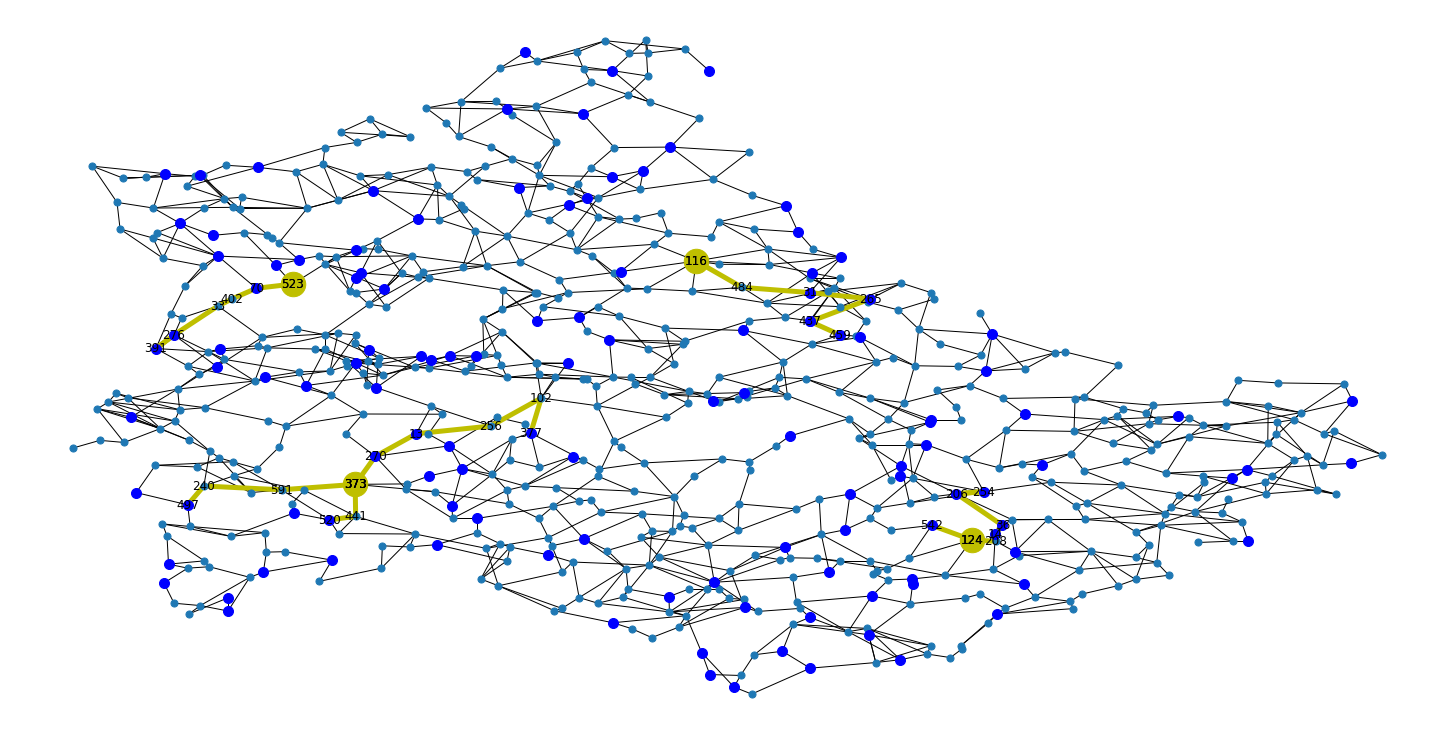

In [31]:
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,pos=pos,node_size=50)

nx.draw_networkx_nodes(G,pos,nodelist=depot_genes,node_color='y',node_size=600,alpha=1);
nx.draw_networkx_labels(G,pos,{k:k for k in depot_genes});
nx.draw_networkx_nodes(G,pos,nodelist=cust_genes,node_color='b',node_size=100,alpha=1);
with open('1223.json') as json_file:
    js = json.load(json_file)
    data=json.loads((js))
    for lorry in data:
        path=[]
        
        for index,location in enumerate(lorry['loc']):            
            if index < len(lorry['loc']) -2:
                path =path + nx.shortest_path(G,source=location[0],target=lorry['loc'][index+1][0])
#         for index,each in enumerate(path):
#             if index ==0:
#                 distance = nx.shortest_path(G,source=each,target=each[index+1])
#             elif index < len(path)-2:
#                 distance =distance + nx.shortest_path(G,source=each[index],target=each[index+1])
        sp_edges= list(zip(path,path[1:]))
        nx.draw_networkx_labels(G,pos,{k:k for k in path});
        nx.draw_networkx_edges(G,pos,edgelist=sp_edges,edge_color='y',width=5)